# Assignment 1 - Coding Section

## Follow the codes, comments and the explanations. There are 3 problems in total which are worth 70 points. You are going to add your code in this notebook.

### For this assignment, we will create a dataset consisting of black-and-white images of circles. The task is to estimate the radius and location of the ball based on the image using various Least Squares techniques.




---


# ***Important Note:***

## You need to write your report, including the results, plots, and analyses/discussion, in a PDF file. Submit this PDF file along with your theory solutions. Additionally, upload your Jupyter notebook (.ipynb) file alongside the PDF.







#Section One: Dataset

## Importing necessary libraries




In [46]:
import numpy as np                # NumPy: Numerical computing with arrays and matrices
import pandas as pd               # Pandas: Data manipulation and analysis with DataFrames
import cv2                        # OpenCV: Computer vision, image, and video processing
import random                     # Random: Generating random numbers and selections
import matplotlib.pyplot as plt   # Matplotlib: Creating visualizations and plots
from PIL import Image, ImageDraw  # Pillow: Image file opening, manipulation, and saving
from sklearn.model_selection import train_test_split  # Scikit-learn: Splitting datasets for machine learning

## Parameters

In [47]:
image_size = 30                       # Size of the generated images (30x30 pixels)
min_radius = 3                        # Minimum circle radius in pixels
max_radius = image_size // 2 - 2      # Maximum circle radius, ensuring circles fit within the image
total_size = 2200                     # Total number of images to generate
noise_level = 0.8                     # Noise level to add to the images

csv_filename = 'generated_images_masks.csv'  # Filename for saving the generated data as a CSV

## Generating the Dataset

This code generates a synthetic dataset of binary images with circular objects embedded within them.

- **Image Size**: Each generated image is 30x30 pixels.
- **Circle Properties**:
  - **Radius**: Randomly chosen between 3 and 13 pixels (ensuring the circle fits within the image boundaries).
  - **Position**: The center of the circle is randomly positioned within the image while ensuring the circle remains fully inside the image boundaries.
- **Noise Level**: Random noise is added to each image, controlled by a `noise_level` parameter (default is 0.8).
- **Total Images**: A total of 2,200 images are generated.
- **Metadata**: Each image is accompanied by metadata, including the circle's radius and its center coordinates `(x, y)`.

The dataset is saved as a CSV file named `generated_images_masks.csv`, where each row corresponds to a single image, with the first three columns representing the metadata (`radius`, `x`, `y`) and the remaining columns representing the flattened pixel values of the binary image.




### Dataset Dimensions

- **Feature Dimensions**: The dataset includes 900 pixel values per image. These pixel values are flattened into a 1D array to create the feature set for each image.
- **Target Variables**: The target variables in the dataset are the circle's radius (`radius`) and its center coordinates (`x`, `y`).
- **Overall Dataset Dimensions**: The resulting dataset has 2,200 rows (one for each image) and 903 columns (3 columns for metadata: `radius`, `x`, `y`, and 900 columns for the pixel values).


In [48]:
def generate_image_with_metadata(image_size, radius, x, y, noise_level=0.8):
    """
    Generate a binary mask with a circle, add random noise, attach metadata (radius, x, y), and return the flattened mask.

    noise_level: Controls the amount of random noise added (default is 0.8).
    """
    # Create a black background image
    img = Image.new('1', (image_size, image_size), color=0)
    draw = ImageDraw.Draw(img)

    # Draw the circle on the binary mask
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill=1)

    # Add random noise to the image
    noise = np.random.rand(image_size, image_size) > noise_level  # Generate random noise
    noisy_mask = np.logical_and(img, noise).astype(np.float32)  # Apply noise to the mask

    # Flatten the noisy mask into a 1D array
    flattened_mask = noisy_mask.flatten()

    # Store the metadata (radius, x, y)
    metadata = [radius, x, y]

    # Combine metadata with the binary mask
    return np.array(metadata + flattened_mask.tolist())


def generate_images_with_masks(total_size, image_size, min_radius, max_radius):
    """
    Generate multiple images with masks by calling the image generation function.
    """
    data = []  # List to store masks and metadata

    for _ in range(total_size):
        # Randomly choose the radius and center (x, y)
        radius = random.randint(min_radius, max_radius)
        x = random.randint(radius + 1, image_size - radius - 1)
        y = random.randint(radius + 1, image_size - radius - 1)

        # Generate a single image with mask and metadata
        single_image_data = generate_image_with_metadata(image_size, radius, x, y, noise_level)
        data.append(single_image_data)

    return np.array(data)

In [49]:
# Generate images with masks (returns a dataset including radius, x, y, and pixel values)
data = generate_images_with_masks(total_size, image_size, min_radius, max_radius)

# Define column names for the DataFrame: radius, x, y, and pixel values
columns = ['radius', 'x', 'y'] + [f'Pixel_{i}' for i in range(image_size * image_size)]

# Create a DataFrame from the generated data with the specified columns
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file without including the index
df.to_csv(csv_filename, index=False)

# Notify the user that the data has been saved to the specified CSV file
print(f"Data saved to {csv_filename}")

Data saved to generated_images_masks.csv


## Visual Exploration of Sample Data Points


In [50]:
# Function to visualize the image
def visualize(image_data, image_size):
    """
    Visualize the image given an array of image data and return the plot object.

    Parameters:
    - image_data: A NumPy array containing image metadata and mask.
    - image_size: The size of the image (width and height, assumed square).

    Returns:
    - fig, ax: The matplotlib figure and axes objects for further modification.
    """
    # Extract metadata from the array (radius and circle center coordinates)
    radius = int(image_data[0])
    x = int(image_data[1])
    y = int(image_data[2])

    # Extract the binary mask from the remaining part of the array
    mask = image_data[3:].astype(np.uint8).reshape(image_size, image_size)

    # Create a grayscale image from the mask
    img = np.zeros((image_size, image_size), dtype=np.uint8)  # Initialize the image with zeros (black)
    img[mask == 1] = 255  # Set the circle area to white (255)

    # Create a figure and axis for plotting
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')  # Display the image in grayscale
    ax.set_title(f"Circle at center ({x}, {y}) with radius {radius}")  # Set title with circle metadata
    ax.axis('off')  # Turn off axis labels and ticks

    # Return the figure and axis for further customization
    return fig, ax

Enter the image index: 10


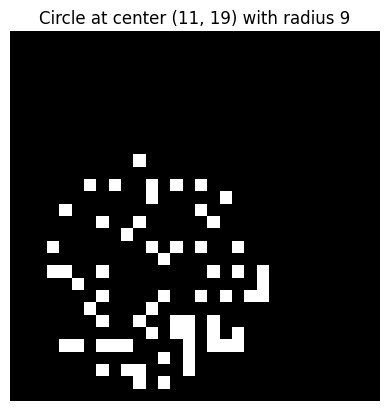

In [51]:
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_filename)

# Prompt the user to enter an image index and extract the corresponding row
image_index = int(input("Enter the image index: "))
image_data = df.iloc[image_index].values  # Get the data for the specified image index

# Visualize the selected image from the DataFrame
_, _ = visualize(image_data, image_size)  # Call the visualize function to display the image

# Section Two: Important functions
Including OLS Solver with MSE and Data Augmentation

In [52]:
# Function to solve ordinary least squares (OLS)
def solve_ols(X_train, Y_train, X_other, alpha):
    """
    Solves the OLS regression problem with regularization (RLS).

    Parameters:
    - X_train: The training input data (features).
    - Y_train: The training output data (targets).
    - X_other: The input data (features) for the other dataset (e.g., validation or test).
    - alpha: Regularization parameter.

    Returns:
    - Y_LS_train: Predicted outputs for the training data.
    - Y_LS_other: Predicted outputs for the other dataset.
    """
    # Calculate the weights (W) using the pseudo-inverse and regularization
    W = np.dot(np.linalg.pinv(np.dot(X_train.T, X_train) + alpha * np.identity(np.shape(X_train)[1])), np.dot(X_train.T, Y_train))


    Y_LS_train = np.dot(X_train, W)
    Y_LS_other = np.dot(X_other, W)
    # Return predictions for both training and other data
    return Y_LS_train, Y_LS_other

In [53]:
# Function to run OLS, compute MSE, and output results and labels
def run_ols(X_train, X_other, Y_train, Y_other, alpha, augment=False):
    """
    Runs the OLS regression, computes the MSE for both training and another dataset (e.g., validation/test), and returns results.

    Parameters:
    - X_train: The training input data (features).
    - X_other: The input data (features) for the other dataset (e.g., validation or test).
    - Y_train: The training output data (targets).
    - Y_other: The output data (targets) for the other dataset (e.g., validation or test).
    - alpha: Regularization parameter (ridge regression).
    - augment: Boolean indicating whether to augment data by adding a bias term.

    Returns:
    - mse_train: Mean squared error on the training set.
    - mse_other: Mean squared error on the other dataset.
    - Y_LS_train: Predicted outputs for the training data.
    - Y_LS_other: Predicted outputs for the other dataset.
    """
    if augment:
        # Augment the data by adding a bias term (column of ones)
        X_train = augment_data(X_train)
        X_other = augment_data(X_other)

    # Perform OLS regression to get predictions
    Y_LS_train, Y_LS_other = solve_ols(X_train, Y_train, X_other, alpha)

    # Compute MSE for train and other datasets
    mse_train = compute_mse(Y_LS_train, Y_train)
    mse_other = compute_mse(Y_LS_other, Y_other)

    # Return the MSE and predictions
    return mse_train, mse_other, Y_LS_train, Y_LS_other

In [54]:
# Function to compute mean squared error (MSE)
def compute_mse(Y_pred, Y_true):
    """
    Computes the Mean Squared Error (MSE) between predicted and true values.

    Parameters:
    - Y_pred: Predicted values.
    - Y_true: True values.

    Returns:
    - mse: The mean squared error.
    """
    mse = np.square(np.linalg.norm(Y_pred - Y_true)) / Y_true.size
    return mse

In [55]:
# Function to augment data by adding a bias (for non-homogeneous models)
def augment_data(X):
    """
    Augments the data by adding a bias column (column of ones).

    Parameters:
    - X: The input data to augment.

    Returns:
    - Augmented input data with an added bias column.
    """
    ones_column = np.ones((X.shape[0], 1))
    return np.concatenate((X, ones_column), axis=1)

In [56]:
# Function to report true and predicted circles
def prediction_report(true_data, predicted_data, predicted_data_aug, index):
    """
    Prints a report of true and predicted circle parameters (radius and center coordinates).

    Parameters:
    - true_data: Array containing true circle parameters (radius, x, y).
    - predicted_data: Array containing predicted circle parameters using a homogeneous model.
    - predicted_data_aug: Array containing predicted circle parameters using a non-homogeneous model.
    - index: Index of the circle data to report.

    Outputs:
    - Prints the true and predicted values for the selected circle.
    """
    # Extract true and predicted values for the selected index
    true_radius, true_x, true_y = true_data[index]
    pred_radius, pred_x, pred_y = predicted_data[index]
    augp_radius, augp_x, augp_y = predicted_data_aug[index]

    # Report the true and predicted values
    print(f"True values - Radius: {true_radius}, x: {true_x}, y: {true_y}")
    print(f"Predicted homogeneous model values - Radius: {pred_radius:.2f}, x: {pred_x:.2f}, y: {pred_y:.2f}")
    print(f"Predicted non-homogeneous model values - Radius: {augp_radius:.2f}, x: {augp_x:.2f}, y: {augp_y:.2f}")

# Section Three: Questions

## PROBLEM 1 (20 marks): Predicting radius, x, and y using OLS

In [57]:
# Load dataset from the CSV file
df = pd.read_csv(csv_filename)  # Load the image data with metadata from a CSV file

# Extract features by dropping the target columns ('radius', 'x', 'y')
X = df.drop(columns=['radius', 'x', 'y']).values  # Features (only pixel data)

# Extract target values (radius, x, and y)
Y = df[['radius', 'x', 'y']].values  # Labels (radius, x, and y)



---



---



### PART 1 (10 marks):

---



---


1. ### Divide the dataset into three parts: 1800 samples for training, 200 samples for validation, and 200 samples for testing. Perform linear OLS (without regularization) on the training samples twice—first with a homogeneous model (i.e., where the y-intercepts are zero) and then with a non-homogeneous model (allowing for a non-zero y-intercept). Report the MSE on both the training data and the validation data for each model.

3. ### Compare the results. Which approach performs better? Why? Apply the better-performing approach to the test set and report the MSE.

2. ### Do you observe significant overfitting in any of the cases?










In [58]:
# Specify the number of training, validation, testing samples.

    ############################################################################
    ############################################################################
    #### Use the variable names "train_size", "valid_size", and "test_size" ####
    #### for the training, validation, and test sizes, respectively.        ####
    ############################################################################
    ############################################################################

train_size = 1800
valid_size = 200
test_size = 200


In [59]:
def split_dataset(X, Y, total_size, train_size, valid_size):
    """
    Splits the dataset into training, validation, and test sets.

    Parameters:
    X (array-like): Feature data.
    Y (array-like): Target data.
    total_size: Total number of data to consider.
    train_size: number of the data to include in the training set.
    valid_size: number of the data to include in the validation set.

    Returns:
    X_train, X_valid, X_test, Y_train, Y_valid, Y_test: Split datasets.

    """

    ##############################################
    ##############################################
    #### DO NOT CHANGE THE INPUTS AND OUTPUTS ####
    ##############################################
    ##############################################

    X_train, X_remaining, Y_train, Y_remaining = train_test_split(X, Y, train_size=train_size/total_size, random_state=42)
    # Split the remaining data into validation and test sets
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_remaining, Y_remaining, train_size=valid_size/(total_size-train_size), random_state=42)


    ################################################
    ################################################
    #### HINT: you can use the train_test_split ####
    #### function from sklearn.model_selection  ####
    ################################################
    ################################################

    return X_train, X_valid, X_test, Y_train, Y_valid, Y_test

In [60]:
# Here we use the previous function to split our dataset into three parts.
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split_dataset(X, Y, total_size, train_size, valid_size)

In [61]:
# Run OLS regression without adding a bias term (homogeneous model)

mse_train_h, mse_valid_h, Y_LS_train_h, Y_LS_valid_h = run_ols(X_train, X_valid, Y_train, Y_valid, 0, augment=False)

# Output the results for the homogeneous model

print(f"MSE on validation data: {mse_valid_h}")

MSE on validation data: 93.21870200576788


In [62]:
# Run OLS regression with a bias term added (non-homogeneous model)

mse_train_nh, mse_valid_nh, Y_LS_train_nh, Y_LS_valid_nh = run_ols(X_train, X_valid, Y_train, Y_valid, 0, augment=True)

# Output the results for the non-homogeneous model

print(f"MSE on validation data: {mse_valid_nh}")

MSE on validation data: 12.131804381460546


In [63]:
# In this code you can see the predictions you've made using your model.

# Prompt the user to enter an index for prediction reporting
index = int(input("Enter the index for prediction: "))

# Generate and print the prediction report for the specified index
# Use the prediction_report function and index to see your predictions

prediction_report(Y_train, Y_LS_train_h, Y_LS_train_nh, index)



Enter the index for prediction: 10
True values - Radius: 9.0, x: 16.0, y: 18.0
Predicted homogeneous model values - Radius: 8.10, x: 12.56, y: 17.42
Predicted non-homogeneous model values - Radius: 8.53, x: 14.65, y: 19.50


In [64]:
# Run OLS regression with a bias term added on test set

mse_train_nh, mse_test_nh, Y_LS_train_nh, Y_LS_test_nh = run_ols(X_train, X_test, Y_train, Y_test, 0, augment=True)

print(f"MSE on test data: {mse_test_nh}")

MSE on test data: 6.752516213105869




---



---



### PART 2 (10 marks):


---



---


1. ### Divide the dataset into three parts: 200 samples for training, 1800 samples for validation, and 200 samples for testing. Perform linear OLS (without regularization) on the training samples twice—first with a homogeneous model (i.e., where the y-intercepts are zero) and then with a non-homogeneous model (allowing for a non-zero y-intercept). Report the MSE on both the training data and the validation data for each model.

2. ### Compare these results with those from the previous part. Do you observe less overfitting or more overfitting? How did you arrive at this conclusion?



In [65]:
# Specify the number of training, validation, testing samples.

train_size = 200
valid_size = 1800
test_size = 200

In [66]:
# Here we use the split_dataset function to split our dataset into three parts.
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split_dataset(X, Y, total_size, train_size, valid_size)

In [67]:
# Run OLS regression without adding a bias term (homogeneous model)

mse_train_h, mse_valid_h, Y_LS_train_h, Y_LS_valid_h = run_ols(X_train, X_valid, Y_train, Y_valid, 0, augment=False)

# Output the results for the homogeneous model

print(f"MSE on validation data: {mse_valid_h}")

MSE on validation data: 136.1720097569239


In [68]:
# Run OLS regression with a bias term added (non-homogeneous model)

mse_train_nh, mse_valid_nh, Y_LS_train_nh, Y_LS_valid_nh = run_ols(X_train, X_valid, Y_train, Y_valid, 0, augment=True)

# Output the results for the non-homogeneous model

print(f"MSE on validation data: {mse_valid_nh}")

MSE on validation data: 14.035596029110454


In [69]:
# In this code you can see the predictions you've made using your model.

# Prompt the user to enter an index for prediction reporting
index = int(input("Enter the index for prediction: "))

# Generate and print the prediction report for the specified index
# Use the prediction_report function and index to see your predictions

prediction_report(Y_train, Y_LS_train_h, Y_LS_train_nh, index)

Enter the index for prediction: 10
True values - Radius: 5.0, x: 21.0, y: 13.0
Predicted homogeneous model values - Radius: 5.00, x: 21.00, y: 13.00
Predicted non-homogeneous model values - Radius: 5.00, x: 21.00, y: 13.00


In [70]:
# Run OLS regression with a bias term added on test set

mse_train_nh, mse_test_nh, Y_LS_train_nh, Y_LS_test_nh = run_ols(X_train, X_test, Y_train, Y_test, 0, augment=True)

# Output the results for the better performing approach

print(f"MSE on test data: {mse_test_nh}")

MSE on test data: 14.65811160203486


## PROBLEM 2 (20 marks): Regularized Least Squares



In [71]:
# Load dataset from the CSV file
df = pd.read_csv(csv_filename)  # Load the image data with metadata from a CSV file

# Extract features by dropping the target columns ('radius', 'x', 'y')
X = df.drop(columns=['radius', 'x', 'y']).values  # Features (only pixel data)

# Extract target values (radius, x, and y)
Y = df[['radius', 'x', 'y']].values  # Labels (radius, x, and y)



---



---



### PART 1 (15 marks):

---



---

1. ### Divide the Dataset into Three Parts:
- **Training Data**: Select **200 data points**.
- **Validation Data**: Assign **1800 data points**.
- **Testing Data**: Set aside the **remaining 200 data points** for testing.


2. ### Run Regularized Least Squares (non-homogeneous) using 200 training data points. Choose various values of lambda within the range {exp(-2), exp(-1.5), exp(-1), …, exp(3.5), exp(4)}. This corresponds to λ values ranging from exp(-2) to exp(4) with a step size of 0.5. For each value of lambda, Run Regularized Least Squares (non-homogeneous) using 200 training data points. Compute the Training MSE and Validation MSE.


3. ### Plot the Training MSE and Validation MSE as functions of lambda.





* **IMPORTANT NOTE:** Use the variable name "alpha" for the values of the regularization parameter (previously referred to as "lambda") in Python code, since "lambda" is a reserved keyword in Python.

In [72]:
# Specify the number of training, validation, testing samples.

train_size = 200
valid_size = 1800
test_size = 200

In [73]:
# Here we use the split_dataset function to split our dataset into three parts.
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split_dataset(X, Y, total_size, train_size, valid_size)

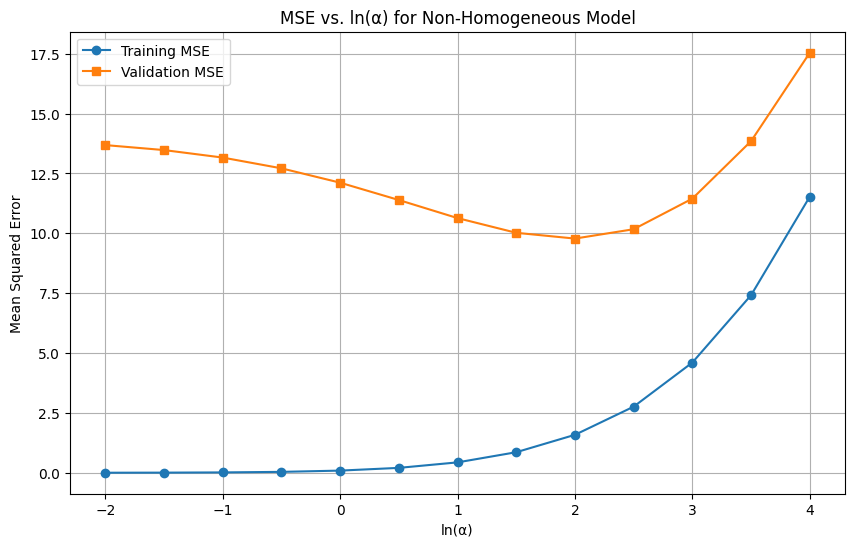

In [74]:
# Define a range of alpha values (regularization parameters) using an exponential scale

mse_train = []
mse_valid = []

exponents = np.arange(-2, 4.5, 0.5)  # 4.5 ensures 4 is included
alphas = np.exp(exponents)

    ###############################################
    ###############################################
    #### HINT: you can use the np.exp function ####
    ###############################################
    ###############################################


# Iterate over the range of alpha values
for alpha in alphas:

    # Run RLS regression with a bias term added on train and validation sets
    mse_train_nh, mse_valid_nh, Y_LS_train_nh, Y_LS_valid_nh = run_ols(X_train, X_valid, Y_train, Y_valid, alpha, augment=True)
    mse_train.append(mse_train_nh)
    mse_valid.append(mse_valid_nh)

# Plot the MSE for the non-homogeneous model across different alphas
plt.figure(figsize=(10, 6))
plt.plot(np.log(alphas), mse_train, marker='o', label='Training MSE')
plt.plot(np.log(alphas), mse_valid, marker='s', label='Validation MSE')
plt.xlabel('ln(α)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. ln(α) for Non-Homogeneous Model')
plt.legend()
plt.grid(True)
plt.show()





---



---


### PART 2 (5 marks):


---



---



1. ### What is the best value for lambda? Why?

2. ### Use the best value of lambda to report the results on the test set.

In [75]:
# Here you find the best value of lambda

min_index = np.argmin(mse_valid)
best_alpha = alphas[min_index]

print(f"The best value of lambda is: {best_alpha}")

The best value of lambda is: 7.38905609893065


In [76]:
# Run OLS regression with a bias term added (non-homogeneous model)

mse_train_nh, mse_valid_nh, Y_LS_train_nh, Y_LS_valid_nh = run_ols(X_train, X_test, Y_train, Y_test, best_alpha, augment=True)

# Output the results for the non-homogeneous model

print(f"MSE on validation data: {mse_valid_nh}")

MSE on validation data: 9.816649057969363


## PROBLEM 3 (30 marks): Preprocessing the data


### In this question, we aim to improve the results of Regularized Least Squares (RLS) while still using only 200 training points and 1800 validation points. To achieve this, we will map the data points into a new space and then run RLS. In other words, we will preprocess X_train, X_valid, and X_test to obtain new Z_train, Z_valid, and Z_test datasets, which will have the same number of points but a different number of features.

###NOTE: You will only get full mark in this question if your approach improves over the naive use of RLS we observed in the previous questions.



---
---
### PART 1 (5 marks):
---
---

 - ## Choose a preprocessing approach (i.e., select a mapping) that transforms the 900-dimensional data points (900 pixels) into a new space. This new space can be either lower-dimensional or higher-dimensional. Clearly explain your preprocessing approach.

---
---
### PART 2 (10 marks):
---
---



- ## Implement your preprocessing approach. Then, run non-homogeneous Regularized Least Squares (RLS) in the new space for training set and validation set.

In [77]:
# Load dataset from the CSV file
df = pd.read_csv(csv_filename)  # Load the image data with metadata from a CSV file

# Extract features by dropping the target columns ('radius', 'x', 'y')
X = df.drop(columns=['radius', 'x', 'y']).values  # Features (only pixel data)

# Extract target values (radius, x, and y)
Y = df[['radius', 'x', 'y']].values  # Labels (radius, x, and y)

# Define a function to transforms pixel values to a new space.
def transform(X_df):

  X_df_transform = []

  for row in X_df:

    positions = []
    pixels = np.array(row)
    image = pixels.reshape(image_size, image_size)

    for image_row in image:
        if np.any(pixels != 0):
          first_pos = np.where(row != 0)[0][0]
          last_pos = len(row) - np.where(row[::-1] != 0)[0][0] - 1
          reversed_row = image_row[::-1]
          last_non_zero = last_pos - np.argmax(reversed_row != 0)
        else:
          first_non_zero = -1
          last_non_zero = -1

        positions.extend([first_pos, last_pos])

    positions = np.array(positions)
    X_df_transform.append(positions)

  processed_X_df = pd.DataFrame(X_df_transform)

  return processed_X_df

# Apply the transform function to the DataFrame
processed_X_df = transform(X)

# Display the first few rows of the updated DataFrame
processed_X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,106,505,106,505,106,505,106,505,106,505,...,106,505,106,505,106,505,106,505,106,505
1,103,828,103,828,103,828,103,828,103,828,...,103,828,103,828,103,828,103,828,103,828
2,162,705,162,705,162,705,162,705,162,705,...,162,705,162,705,162,705,162,705,162,705
3,111,475,111,475,111,475,111,475,111,475,...,111,475,111,475,111,475,111,475,111,475
4,260,563,260,563,260,563,260,563,260,563,...,260,563,260,563,260,563,260,563,260,563


---
---
### PART 3 (15 marks):
---
---


- ## Report the MSE on the training and validation sets for different values of lambda and plot it. **As mentioned, it should perform better for getting points.** choose the best value of lambda, apply your preprocessing approach to the test set, and then report the MSE after running RLS.



In [78]:
# Specify the number of training, validation, testing samples.

train_size = 200
valid_size = 1800
test_size = 200

In [79]:
########################################################
########################################################
#### Please take note that we insert processed_X_df ####
#### as the new input for splitting                 ####
########################################################
########################################################
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split_dataset(processed_X_df, Y, total_size, train_size, valid_size)

In [80]:
# Define a range of alpha values (regularization parameters) using an exponential scale

mse_train = []
mse_valid = []

exponents = np.arange(-2, 4.5, 0.5)  # 4.5 ensures 4 is included
alphas = np.exp(exponents)

for alpha in alphas:

    # Run RLS regression with a bias term added on train and validation sets
    mse_train_nh, mse_valid_nh, Y_LS_train_nh, Y_LS_valid_nh = run_ols(X_train, X_valid, Y_train, Y_valid, alpha, augment=True)
    mse_train.append(mse_train_nh)
    mse_valid.append(mse_valid_nh)

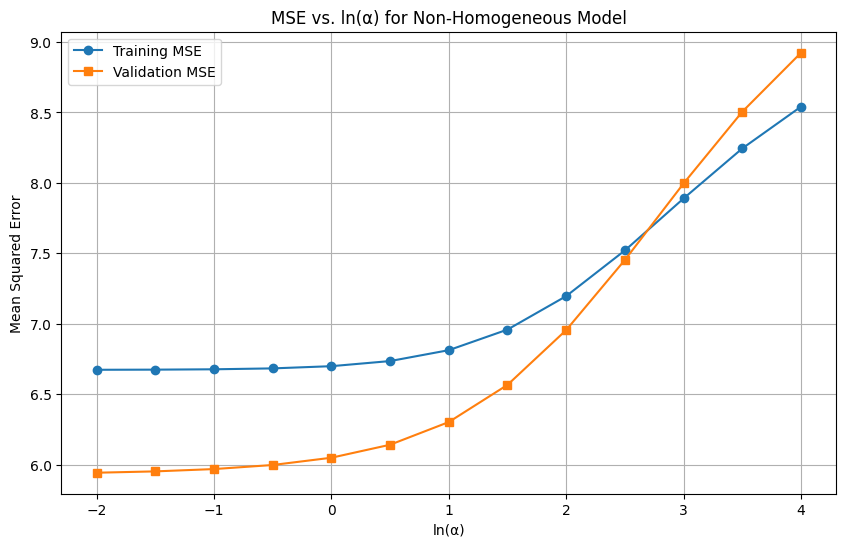

In [81]:
# Plot the MSE for the non-homogeneous model across different alphas
plt.figure(figsize=(10, 6))
plt.plot(np.log(alphas), mse_train, marker='o', label='Training MSE')
plt.plot(np.log(alphas), mse_valid, marker='s', label='Validation MSE')
plt.xlabel('ln(α)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. ln(α) for Non-Homogeneous Model')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Here you find the best value of lambda

min_index = np.argmin(mse_valid)
best_alpha = alphas[min_index]

print(f"The best value of lambda is: {best_alpha}")

The best value of lambda is: 0.1353352832366127


In [83]:
# Run OLS regression with a bias term added (non-homogeneous model)

mse_train_nh, mse_test_nh, Y_LS_train_nh, Y_LS_test_nh = run_ols(X_train, X_test, Y_train, Y_test, best_alpha, augment=True)

# Output the results for the non-homogeneous model

print(f"MSE on test data: {mse_test_nh}")

MSE on test data: 6.0871978263818285
